In [171]:
import numpy as np
import cv2
import math
from skimage.transform import hough_circle, hough_circle_peaks
import matplotlib.pyplot as plt
from skimage.filters.rank import equalize
from skimage.morphology import disk
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

In [172]:

def IrisLocalization(eye): # input is the eye image in grayscale
    blured = cv2.bilateralFilter(eye, 9, 100, 100) # remove noise
    Xp = blured.sum(axis=0).argmin() # index of the column with the least sum
    Yp = blured.sum(axis=1).argmin() # index of the row with the least sum
    x = blured[max(Yp - 60, 0):min(Yp + 60, 280), max(Xp - 60, 0):min(Xp + 60, 320)].sum(axis=0).argmin()
    y = blured[max(Yp - 60, 0):min(Yp + 60, 280), max(Xp - 60, 0):min(Xp + 60, 320)].sum(axis=1).argmin()
    Xp = max(Xp - 60, 0) + x
    Yp = max(Yp - 60, 0) + y
    if Xp >= 100 and Yp >= 80: # check if the pupil center is not too close to the edge
        blur = cv2.GaussianBlur(eye[Yp - 60:Yp + 60, Xp - 60:Xp + 60], (5, 5), 0)
        pupil_circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=200, param1=200, param2=12, minRadius=15, maxRadius=80)
        xp, yp, rp = np.round(pupil_circles[0][0]).astype("int")
        xp = Xp - 60 + xp
        yp = Yp - 60 + yp
    else:
        pupil_circles = cv2.HoughCircles(blured, cv2.HOUGH_GRADIENT, 4, 280, minRadius=25, maxRadius=55, param2=51)
        xp, yp, rp = np.round(pupil_circles[0][0]).astype("int")

    # Draw the circle on the original image
    fig, ax = plt.subplots()
    ax.imshow(eye, cmap='gray')  # Display the grayscale image
    pupil_circle = plt.Circle((xp, yp), rp, color='red', fill=False, linewidth=2)  # Red circle
    ax.add_patch(pupil_circle)
    ax.plot(xp, yp, 'bo')  # Blue point at the center
    plt.title("Detected Pupil Circle")
    plt.axis('off')  # Turn off axes for better visualization
    plt.show()

    eye_copy = eye.copy()
    rp = rp + 7 # slightly enlarge the pupil radius makes a better result
    blured_copy = cv2.medianBlur(eye_copy, 11)
    blured_copy = cv2.medianBlur(blured_copy, 11)
    blured_copy = cv2.medianBlur(blured_copy, 11)
    eye_edges = cv2.Canny(blured_copy, threshold1=15, threshold2=30, L2gradient=True) # edge detection

    # Display the edge-detected image with pupil edges
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("With Pupil Edges")
    plt.imshow(eye_edges, cmap='gray')

    # Remove the edge of the pupil
    eye_edges[:, xp - rp - 30:xp + rp + 30] = 0

    # Display the edge-detected image without pupil edges
    plt.subplot(1, 2, 2)
    plt.title("Without Pupil Edges")
    plt.imshow(eye_edges, cmap='gray')
    plt.show()

    hough_radii = np.arange(rp+45, 150, 2) # possible iris radii
    hough_res = hough_circle(eye_edges, hough_radii) # hough transform to detect circles with different radii
    accums, xi, yi, ri = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1) # find the mostt prominent circle (peak) to be the iris circle
    iris = [] # iris circle
    iris.extend(xi)
    iris.extend(yi)
    iris.extend(ri)
    if ((iris[0] - xp) ** 2+(iris[1]-yp)**2) ** 0.5 > rp* 0.3: # using Euclidean distance to check if the iris circle is too far from the pupil, use the pupil circle instead
        iris[0] = xp
        iris[1] = yp
    
    fig, ax = plt.subplots()
    ax.imshow(eye, cmap='gray')  # Display the grayscale image
    # Draw the blue circle for the iris
    iris_circle = plt.Circle((iris[0], iris[1]), iris[2], color='blue', fill=False, linewidth=2)
    ax.add_patch(iris_circle)
    ax.plot(iris[0], iris[1], 'bo')  # Blue point at the iris center
    # Configure the plot
    plt.title("Without Pupil Edges")
    plt.axis('off')  # Turn off axes for better visualization
    plt.show()

    return np.array(iris), np.array([xp,yp,rp]) # return the iris and pupil circles

In [173]:
def IrisNormalization(image,inner_circle,outer_circle ):
    localized_img=image
    row=64
    col=512
    normalized_iris=np.zeros(shape=(64,512))
    inner_y=inner_circle[0]  #height
    inner_x=inner_circle[1] #width
    outer_y=outer_circle[0]
    outer_x=outer_circle[1]
    angle=2.0*math.pi/col
    # 1 row 512 col
    inner_boundary_x = np.zeros(shape=(1,col)) # x coordinate of pupil boundary for each angle
    inner_boundary_y = np.zeros(shape=(1,col)) # y coordinate of pupil boundary for each angle
    outer_boundary_x = np.zeros(shape=(1,col)) # x coordinate of iris boundary for each angle
    outer_boundary_y = np.zeros(shape=(1,col)) # y coordinate of iris boundary for each angle
    for j in range(col):


        inner_boundary_x[0][j]=inner_circle[0]+inner_circle[2]*math.cos(angle*(j))
        inner_boundary_y[0][j]=inner_circle[1]+inner_circle[2]*math.sin(angle*(j))
        
        outer_boundary_x[0][j]=outer_circle[0]+outer_circle[2]*math.cos(angle*(j))
        outer_boundary_y[0][j]=outer_circle[1]+outer_circle[2]*math.sin(angle*(j))
        
    for j in range (512):
        for i in range (64):
            normalized_iris[i][j]=localized_img[
                min(int(int(inner_boundary_y[0][j])+(int(outer_boundary_y[0][j])-int(inner_boundary_y[0][j]))*(i/64.0)),localized_img.shape[0]-1)
            ][
                min(int(int(inner_boundary_x[0][j])+(int(outer_boundary_x[0][j])-int(inner_boundary_x[0][j]))*(i/64.0)),localized_img.shape[1]-1)
            ]

    res_image=255-normalized_iris

    plt.imshow(normalized_iris, cmap='gray')
    plt.title("Normalized Iris")
    plt.show()
    return res_image

In [174]:
def ImageEnhancement(normalized_iris):
    row=64
    col=512
    normalized_iris = normalized_iris.astype(np.uint8)
    enhanced_image=normalized_iris
    enhanced_image = equalize(enhanced_image, disk(32))
    roi = enhanced_image[0:48,:]
    plt.imshow(roi, cmap='gray')
    plt.title("Enhanced Iris")
    plt.show()
    return roi

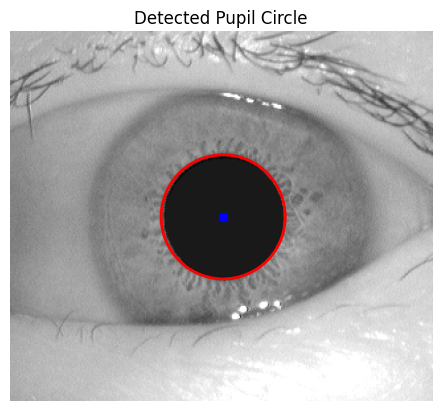

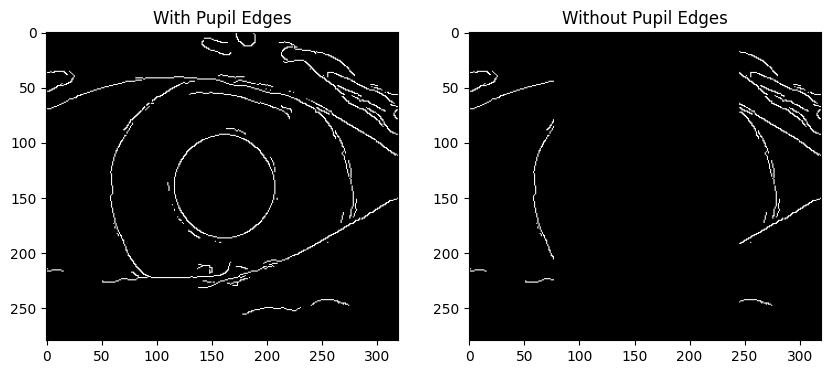

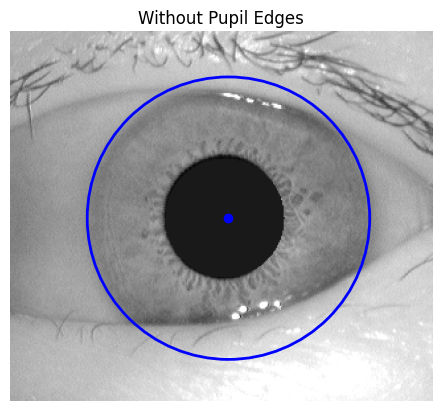

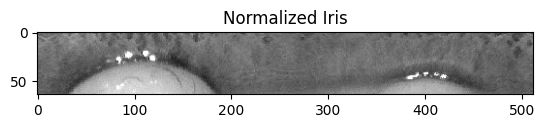

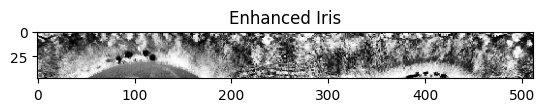

In [178]:
# Example usage
eye = cv2.imread('D:/at school/2024.1/Biometric Authentication System/Project/Biometric/IrisRecognition-master/CASIA Iris Image Database (version 1.0)/006/1/006_1_3.bmp', cv2.IMREAD_GRAYSCALE)
iris, pupil = IrisLocalization(eye)
normalized = IrisNormalization(eye, pupil, iris)
ROI = ImageEnhancement(normalized)

In [176]:
def apply_gabor_filter(image, theta):
    # Create a Gabor filter
    sigma = 4.0
    wavelength = 8.0
    kernel_size = (31, 31)
    kernel = cv2.getGaborKernel(kernel_size, sigma, theta, wavelength, 0.5, 0, ktype=cv2.CV_32F)
    filtered = cv2.filter2D(image, cv2.CV_32F, kernel)
    return filtered

def generate_iris_code(normalized_image):
    # Apply Gabor filters at different orientations
    orientations = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    iris_code = []

    for theta in orientations:
        response = apply_gabor_filter(normalized_image, theta)
        
        # Quantize responses
        real_response = np.real(response)
        imaginary_response = np.imag(response)
        
        # Convert to binary
        real_binary = (real_response > 0).astype(int)
        imaginary_binary = (imaginary_response > 0).astype(int)
        
        # Append to iris code
        iris_code.append(real_binary)
        iris_code.append(imaginary_binary)
    
    # Combine binary codes into a single array
    iris_code = np.concatenate(iris_code, axis=1)
    return iris_code

In [179]:
normalized_image = gaussian_filter(ROI, sigma=1)

iris_code = generate_iris_code(normalized_image)

np.savetxt('iris_code.txt', iris_code, fmt='%d')

In [181]:
def hamming_distance(code1, code2, mask1=None, mask2=None):
    """
    Compute the Hamming distance between two iris codes.
    :param code1: First binary iris code (numpy array).
    :param code2: Second binary iris code (numpy array).
    :param mask1: Mask for code1 (optional).
    :param mask2: Mask for code2 (optional).
    :return: Hamming distance.
    """
    if mask1 is not None and mask2 is not None:
        # Combine masks and exclude masked bits
        combined_mask = mask1 & mask2
        differing_bits = np.sum((code1 ^ code2) & ~combined_mask)
        total_bits = np.sum(~combined_mask)
    else:
        # Without masks
        differing_bits = np.sum(code1 ^ code2)
        total_bits = code1.size
    
    if total_bits == 0:
        return float('inf')  # Handle case where no bits are available for comparison
    return differing_bits / total_bits


In [183]:
# Example usage
# Load iris codes from text files
iris_code1 = np.loadtxt('D:/at school/2024.1/Biometric Authentication System/Project/Biometric/iris_code_1.txt', dtype=int)
iris_code2 = np.loadtxt('D:/at school/2024.1/Biometric Authentication System/Project/Biometric/iris_code_2.txt', dtype=int)

# Compute Hamming distance
distance = hamming_distance(iris_code1, iris_code2)
print(f"Hamming Distance: {distance}")

Hamming Distance: 0.168609619140625
